In [121]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score, RocCurveDisplay, roc_curve, auc

# Chicago Car Crash Analysis

## Overview 
add overview 

## Business Problem

We an advertisement company hired by the City of Chicago to create a series of safe driving Public Safety Anncouncements for young adults. 

These ads will run on social media as well as being posted near high schools and college campuses. 

In order to figure out what ads will be the most effective, we are examining the causes of accidents for two age ranges: 15-18 year olds and 18-22 year olds. Once we determine the most common causes of accidents, we will be able to tailor our ads for the city, and hopefully reduce accidents for our target group.

## Data Source 

Car crash and vehicle accident data was sourced from the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d/about_data). It originates from the [City of Chicago](http://www.chicago.gov/)

Data collection began in 2015, but was only adopted by all police departments in 2017. The most recent data entry was from September 26, 2024. 

## Results

add results

# Data Import and Cleaning 

In [122]:
#df_vehicles = pd.read_csv("data/Traffic_Crashes_Vehicles.csv")
#df_people = pd.read_csv("data/Traffic_Crashes_People.csv")
#df_crashes = pd.read_csv("data/Traffic_Crashes_Crashes.csv")

## Merge Dataframes

First we sample 300,000 crash reports, then we merge the vehicle and people involved. 

In [123]:
#Random sample of vehicles 
#df_accidents = df_vehicles.sample(n=300000, random_state=42)

In [124]:
#Then we can add the crash report data 
#df_accidents = df_accidents.merge(df_crashes, how="inner", on=["CRASH_RECORD_ID", "CRASH_DATE"])

In [125]:
#every person and vehicle should have a match for the record ID, vehicle ID, and crash date
#This makes the dataframe larger as multiple people are involved in each accident 
#df_accidents = df_accidents.merge(df_people, how="inner", on=["CRASH_RECORD_ID", "VEHICLE_ID", "CRASH_DATE"])

The dataframe gets larger when merging in the people, as there are sometimes more than one person involved in an accident.  

# THIS IS FOR WORKING PURPOSES. 

# USE THIS TO IMPORT DF WITHOUT RUNNING THE CELLS ABOVE.

## Export Final

In [126]:
#df_accidents.to_csv('data/Final_Data.csv')

## Read Final

In [127]:
df_accidents = pd.read_csv("data/Final_Data.csv")

/var/folders/4f/cr2zm2px70q9hrgj23zmw7_r0000gn/T/ipykernel_81966/2274169522.py:1: DtypeWarning: Columns (19,21,40,41,42,44,48,49,50,55,58,59,61,71,102,123,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df_accidents = pd.read_csv("data/Final_Data.csv")


In [128]:
#Sets all column names to lowercase
df_accidents.columns = [column.lower() for column in df_accidents.columns]

# ^^^^^ DELETE BEFORE SUBMISSION

In [129]:
#have the crash date as a datetime object. 
df_accidents['crash_date'] = pd.to_datetime(df_accidents['crash_date'], format="%m/%d/%Y %I:%M:%S %p")

df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324360 entries, 0 to 324359
Columns: 144 entries, unnamed: 0 to cell_phone_use
dtypes: datetime64[ns](1), float64(24), int64(9), object(110)
memory usage: 356.4+ MB


## Drop Unnessisary Columns

In [130]:
#remove columns with less than 50% of data present 
df_accidents.dropna(axis=1, thresh = int(0.5*df_accidents.shape[0]), inplace=True)

In [131]:
cols_to_drop = [
#remove unnessisary id columns now the data is joined 
'vehicle_id', 'crash_record_id', 'crash_unit_id',
#drop LAT and LONG (we have location)
'latitude', 'longitude',
#...also drop streets and directions. 
'street_no', 'street_direction', 'street_name', 'travel_direction', 
#police specific 
'beat_of_occurrence', 
#every data entry is in chicago 
'city', 'zipcode', 
#covered by MOST_SEVERE_INJURY
'injury_classification',
#many NAN
'injuries_unknown'
]

df_accidents.drop(columns=cols_to_drop, inplace=True)


In [132]:
#map the weather to a number 

def weather_code(weather):
    """
    Codes are based on https://openweathermap.org/weather-conditions
    0 - Unknown 
    500 - Rain
    600 - Snow
    700 - 'Atmosphere' (Fog, Dust, Haze) 
    800 - Clear
    801 - Clouds 

    """
    if weather == 'CLEAR':
        return 800
    elif weather == 'CLOUDY/OVERCAST':
        return 801
    elif weather == 'RAIN':
        return 500
    elif weather == 'SNOW' or weather == 'FREEZING RAIN/DRIZZLE' or weather== 'SLEET/HAIL' or weather == 'BLOWING SNOW':
        return 600
    elif weather == 'FOG/SMOKE/HAZE' or weather == 'BLOWING SAND/SOIL/DIRT':
        return 700
    else:
        return 0
    
df_accidents['weather_condition'] = df_accidents['weather_condition'].map(weather_code)

In [133]:
#map the injuries to a number 

def injury_severity(severity):
    """
    Injuries are categorized on a scale of 0 to X
    0 - No Indication of Injury 
    1 - REPORTED, NOT EVIDENT 
    2 - NONincapacitating Injury 
    3 - incapacitating Injury 
    4 - Fatal Injury 
    """
    if severity == 'NO INDICATION OF INJURY':
        return 0
    elif severity == 'REPORTED, NOT EVIDENT':
        return 1
    elif severity == 'NONINCAPACITATING INJURY':
        return 2
    elif severity == 'INCAPACITATING INJURY':
        return 3
    elif severity == 'FATAL':
        return 4
    else:
        return 0
    

df_accidents['injury_class'] = df_accidents['most_severe_injury'].map(injury_severity)

In [134]:
#map the crash severity to a number 

def crash_severity(severity):
    """
    Injuries are categorized on a scale of 0 to X
    0 - No Injury / Drive Away 
    1 - Injury and / or tow  
    """
    if severity == 'NO INJURY / DRIVE AWAY':
        return 0
    else:
        return 1
    

df_accidents['crash_type'] = df_accidents['crash_type'].map(crash_severity)

In [135]:
#drop the columns 
in_cols_to_drop = [
#remove counts of each injury 
'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating',
'injuries_reported_not_evident', 'injuries_no_indication'
]

df_accidents.drop(columns=in_cols_to_drop, inplace=True)

In [136]:
df_accidents['prim_contributory_cause'].unique()

array(['UNABLE TO DETERMINE', 'DISREGARDING TRAFFIC SIGNALS',
       'IMPROPER LANE USAGE', 'FOLLOWING TOO CLOSELY',
       'IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING',
       'FAILING TO YIELD RIGHT-OF-WAY',
       'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING STOP SIGN',
       'FAILING TO REDUCE SPEED TO AVOID CRASH', 'NOT APPLICABLE',
       'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
       'IMPROPER BACKING', 'DISTRACTION - FROM INSIDE VEHICLE',
       'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
       'ROAD CONSTRUCTION/MAINTENANCE',
       'EXCEEDING AUTHORIZED SPEED LIMIT',
       'DISTRACTION - FROM OUTSIDE VEHICLE', 'WEATHER',
       'DRIVING ON WRONG SIDE/WRONG WAY',
       'UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)',
       'PHYSICAL CONDITION OF DRIVER', 'EQUIPMENT - VEHICLE CONDITION',
       'CELL PHONE USE OTHER THAN TEXTING', 'DISREGARDING ROAD MARKINGS',
       'VISION OBSCURED (SIGNS, TR

In [137]:
# Categorize primary contributory cause into different categories

def bin_cause(cause):
    
    if cause == 'UNABLE TO DETERMINE':
        return 0
    
    elif cause in ['DISREGARDING TRAFFIC SIGNALS', 'IMPROPER LANE USAGE', 'FOLLOWING TOO CLOSELY', 
                   'IMPROPER TURNING/NO SIGNAL', 'IMPROPER OVERTAKING/PASSING', 'FAILING TO YIELD RIGHT-OF-WAY',
                   'DISREGARDING OTHER TRAFFIC SIGNS', 'DISREGARDING STOP SIGN',
                   'FAILING TO REDUCE SPEED TO AVOID CRASH', 
                   'OPERATING VEHICLE IN ERRATIC, RECKLESS, CARELESS, NEGLIGENT OR AGGRESSIVE MANNER',
                   'IMPROPER BACKING', 'DRIVING SKILLS/KNOWLEDGE/EXPERIENCE',
                   'EXCEEDING AUTHORIZED SPEED LIMIT', 'DRIVING ON WRONG SIDE/WRONG WAY',
                   'DISREGARDING ROAD MARKINGS', 'EXCEEDING SAFE SPEED FOR CONDITIONS', 'DISREGARDING YIELD SIGN',
                   'TURNING RIGHT ON RED', 'BICYCLE ADVANCING LEGALLY ON RED LIGHT', 'PASSING STOPPED SCHOOL BUS',
                   'RELATED TO BUS STOP', 'MOTORCYCLE ADVANCING LEGALLY ON RED LIGHT']:
        return 1
                 
    elif cause in ['UNDER THE INFLUENCE OF ALCOHOL/DRUGS (USE WHEN ARREST IS EFFECTED)', 
                   'HAD BEEN DRINKING (USE WHEN ARREST IS NOT MADE)']:
        return 2
    
    elif cause in ['DISTRACTION - FROM INSIDE VEHICLE', 'DISTRACTION - FROM OUTSIDE VEHICLE', 
                   'CELL PHONE USE OTHER THAN TEXTING', 
                   'DISTRACTION - OTHER ELECTRONIC DEVICE (NAVIGATION DEVICE, DVD PLAYER, ETC.)', 
                   'TEXTING']:
        return 3     
    
 #we may want to look into NOT APPLICABLE to see what that could mean                
    elif cause in ['NOT APPLICABLE', 'PHYSICAL CONDITION OF DRIVER', 
                 'EQUIPMENT - VEHICLE CONDITION', 'VISION OBSCURED (SIGNS, TREE LIMBS, BUILDINGS, ETC.)'
                 'ROAD ENGINEERING/SURFACE/MARKING DEFECTS', 'EVASIVE ACTION DUE TO ANIMAL, OBJECT, NONMOTORIST',
                 'OBSTRUCTED CROSSWALKS', 'ROAD CONSTRUCTION/MAINTENANCE', 'WEATHER', 'ANIMAL']:
        return 4
    else:
        return 0
    
df_accidents['prim_contributory_cause'] = df_accidents['prim_contributory_cause'].map(bin_cause)
df_accidents['sec_contributory_cause'] = df_accidents['prim_contributory_cause'].map(bin_cause)
    

In [138]:
df_accidents['prim_contributory_cause'].isna().value_counts()

prim_contributory_cause
False    324360
Name: count, dtype: int64

In [139]:
df_accidents = df_accidents.loc[(df_accidents['age'] > 14) & (df_accidents['age'] < 23) & (df_accidents['person_type'] == 'DRIVER')]

In [140]:
df_accidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18349 entries, 41 to 324345
Data columns (total 51 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   unnamed: 0               18349 non-null  int64         
 1   crash_date               18349 non-null  datetime64[ns]
 2   unit_no                  18349 non-null  int64         
 3   unit_type                18349 non-null  object        
 4   make                     18340 non-null  object        
 5   model                    18338 non-null  object        
 6   lic_plate_state          17688 non-null  object        
 7   vehicle_year             17588 non-null  float64       
 8   vehicle_defect           18341 non-null  object        
 9   vehicle_type             18341 non-null  object        
 10  vehicle_use              18341 non-null  object        
 11  maneuver                 18341 non-null  object        
 12  occupant_cnt             18341 non-

# Mapping BAC and Vehicle defects

In [141]:
def vehicle_defect_clf(defect):
    ''' 
    0 = No / Unknown defect

    1 = Has a defect 
    '''
    if defect in ['NONE', 'UNKNOWN']:
        return 0
    return 1

df_accidents['vehicle_defect'] = df_accidents['vehicle_defect'].map(vehicle_defect_clf)

In [142]:
df_accidents['sec_contributory_cause'].value_counts()

sec_contributory_cause
0    18349
Name: count, dtype: int64

## Examine Correlations

In [143]:
matrix = df_accidents.corr(numeric_only=True)
print(matrix)

                         unnamed: 0   unit_no  vehicle_year  vehicle_defect  \
unnamed: 0                 1.000000 -0.010264      0.005423        0.001029   
unit_no                   -0.010264  1.000000      0.025821       -0.062218   
vehicle_year               0.005423  0.025821      1.000000        0.002782   
vehicle_defect             0.001029 -0.062218      0.002782        1.000000   
occupant_cnt              -0.011096  0.050480      0.002097       -0.003313   
posted_speed_limit        -0.011509  0.045530      0.004154       -0.001314   
weather_condition         -0.003638  0.000385      0.005804        0.005148   
crash_type                -0.011119 -0.038502     -0.004265        0.052924   
prim_contributory_cause   -0.004047 -0.051086     -0.009363        0.123028   
sec_contributory_cause          NaN       NaN           NaN             NaN   
num_units                  0.006018  0.189819      0.001659       -0.012655   
injuries_total            -0.009207  0.009364      0

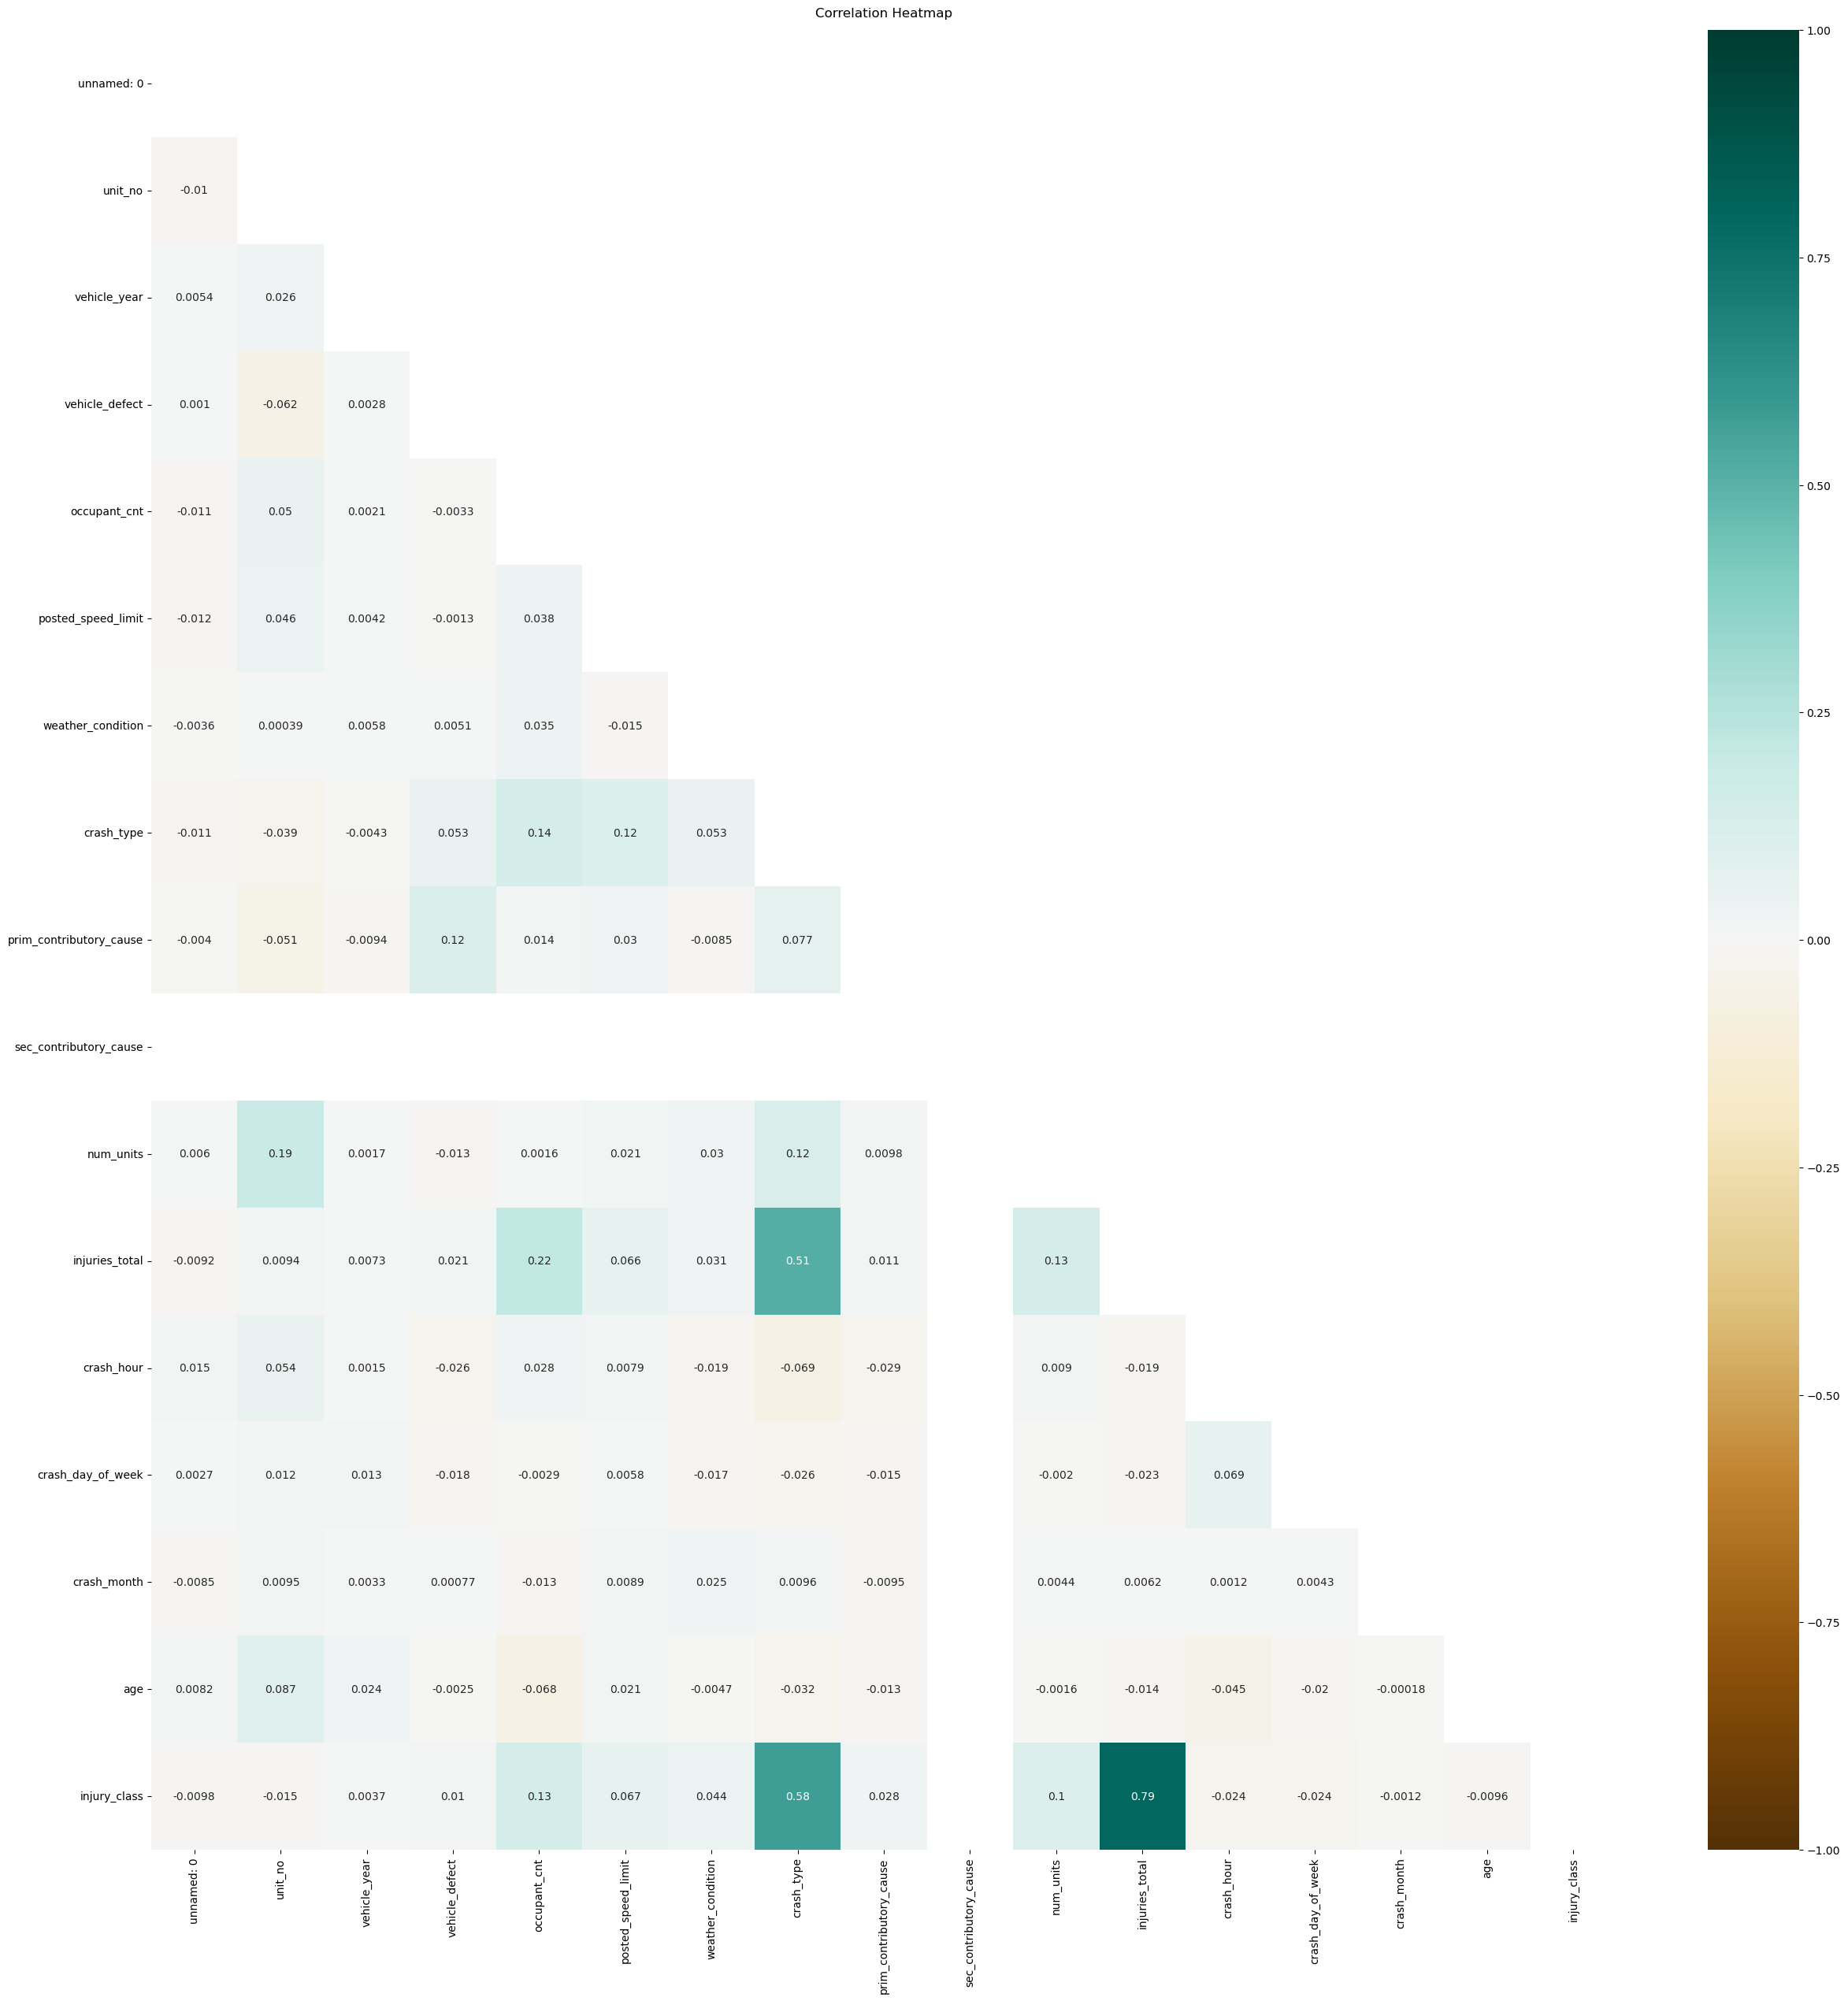

In [144]:
plt.figure(figsize=(30, 30))

#create a mask to remove the duplicate upper half
mask = np.triu(np.ones_like(matrix, dtype=np.bool))

heatmap = sns.heatmap(matrix, vmin=-1, mask=mask, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

# Decision Tree

In [152]:
#Train-Test Split

X = df_accidents.select_dtypes(exclude=['object'])
X = X.drop(columns='prim_contributory_cause') #bug found with categorized data not being a number
X = X.drop(columns=['unnamed: 0', 'crash_date', 'unit_no', 'num_units', 'injuries_total', 'injury_class'])
y = df_accidents['prim_contributory_cause']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=2)

In [153]:
#examine data balance 
y.value_counts()

prim_contributory_cause
1    11090
0     5426
4     1440
3      313
2       80
Name: count, dtype: int64

In [154]:
tree_clf = DecisionTreeClassifier(random_state=42, min_samples_leaf=100)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(min_samples_leaf=100, random_state=42)

In [155]:
print('Training:', tree_clf.score(X_train, y_train))
print('Testing:', tree_clf.score(X_test, y_test))

Training: 0.6183129297333557
Testing: 0.6053246146660439


In [156]:
feature_used = X.columns

for fi, feature in zip(tree_clf.feature_importances_, feature_used):
    print(fi, feature)


0.15496474241960506 vehicle_year
0.0 vehicle_defect
0.03130456572299038 occupant_cnt
0.03221076570104046 posted_speed_limit
0.35849039337404426 weather_condition
0.08026666681788927 crash_type
0.0 sec_contributory_cause
0.14041919706079764 crash_hour
0.0630538561927708 crash_day_of_week
0.095351533699121 crash_month
0.043938279011741035 age


## Combine Columns into Categories 

In [150]:
#py

## Train Test Split

# Model 1

Justification of Model 1

Conclusions from model 1.

# Model 2

Justification of Model 2

Conclusions from model 1.

# Conclusions 

# Next Steps

# Appendix

In [151]:
count = 0
for column in df_accidents.iloc[0]:
    print(df_accidents.columns[count], ":", column, ",", df_accidents.iloc[1].iloc[count])
    count += 1

unnamed: 0 : 41 , 58
crash_date : 2017-11-14 14:30:00 , 2018-09-23 08:00:00
unit_no : 1 , 2
unit_type : DRIVER , DRIVER
make : TOYOTA MOTOR COMPANY, LTD. , DODGE
model : TOYOTA , CHARGER
lic_plate_state : IL , IL
vehicle_year : 2006.0 , 2013.0
vehicle_defect : 0 , 0
vehicle_type : PASSENGER , PASSENGER
vehicle_use : PERSONAL , PERSONAL
maneuver : STRAIGHT AHEAD , STRAIGHT AHEAD
occupant_cnt : 1.0 , 1.0
first_contact_point : FRONT , FRONT
posted_speed_limit : 35 , 35
traffic_control_device : STOP SIGN/FLASHER , TRAFFIC SIGNAL
device_condition : FUNCTIONING PROPERLY , FUNCTIONING PROPERLY
weather_condition : 800 , 800
lighting_condition : DAYLIGHT , DAYLIGHT
first_crash_type : ANGLE , REAR END
trafficway_type : ONE-WAY , DIVIDED - W/MEDIAN BARRIER
alignment : STRAIGHT AND LEVEL , STRAIGHT ON GRADE
roadway_surface_cond : DRY , DRY
road_defect : UNKNOWN , NO DEFECTS
report_type : NOT ON SCENE (DESK REPORT) , ON SCENE
crash_type : 1 , 1
damage : OVER $1,500 , OVER $1,500
date_police_notifie